In [3]:
import os
os.chdir('../') 
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from model.HarsanyiMLP import HarsanyiNet
from utils.data import get_data_loader

In [4]:
train_loader, test_loader, num_classes = get_data_loader('Census', 128)  
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [5]:
model = HarsanyiNet(input_dim=12,
                    num_classes=2,
                    num_layers=3,
                    beta=10,
                    gamma=100,
                    initial_V=1.,
                    act_ratio=0.1,
                    device=device,
                   comparable_DNN=False).to(device)
checkpoint = torch.load('model_pth/Census.pth')

In [6]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
# verify the classification performance 
test_correct_value, test_total_num = 0,0 
model.eval()
for i, (x_te, y_te) in enumerate(test_loader):
    x_te = x_te.to(device)
    y_te = y_te.to(device)
    with torch.no_grad():
        y_pred = model(x_te)
        test_correct_value += (y_pred.max(1)[1] == y_te).sum().item()
        test_total_num += x_te.size(0)
avg_te_acc = test_correct_value / test_total_num
print(f"test_acc: {avg_te_acc:.4f}\n")

test_acc: 0.8485



In [8]:
# compute the Shapley values using HarsanyiNet and calculate the error
from utils.tabular.shapley import HarsanyiNetShapley, BruteForceShapley, get_RMSE, get_sample
train_loader, test_loader, num_classes = get_data_loader('Census', 1)  
sample_id =0

for i, (x_te, y_te) in enumerate(test_loader):
    model = model.double()
    x_te = x_te.to(device)
    x_te = x_te.double()
    y_te = y_te.to(device)
    label = int(y_te)
    if i == sample_id:
        # compute the ground-truth Shapley values
        Shapley_bf = BruteForceShapley(model, x_te, label)
        Harsanyi_Shap = HarsanyiNetShapley(model, x_te, label)
        error = get_RMSE(Shapley_bf, Harsanyi_Shap, 'HarsanyiNet (1)' )
        break

RMSE of HarsanyiNet (1): 8.284137102125136e-17


In [9]:
# compute the Shapley values using other methods
from utils.tabular.shapley import SamplingShapley, PermutationSamplingShapley, KernelPairShapley, KernelShapley, get_RMSE, get_sample, plot_shapleys
train_loader, test_loader, num_classes = get_data_loader('Census', 1)  
sample_id = 0
runs = 5000
for i, (x_te, y_te) in enumerate(test_loader):
    model = model.double()
    x_te = x_te.to(device)
    x_te = x_te.double()
    y_te = y_te.to(device)
    label = int(y_te)
    if i == sample_id:
        # compute the ground-truth Shapley values
        Shapley_bf = BruteForceShapley(model, x_te, label)
        Harsanyi_Shap = HarsanyiNetShapley(model, x_te, label)
        Sampling_Shapley = SamplingShapley(model, x_te, label, runs)
        Permutation_Shapley = PermutationSamplingShapley(model,x_te, label, runs) 
        Kernel_Shap = KernelShapley(model, x_te, label, runs) 
        Kernel_Shap_Pair = KernelPairShapley(model, x_te, label, runs) 
        break

In [10]:
info = pd.read_json('data/Census/info.json')
attributes = info['attributes'].to_list()
data = {'Ground Truth': Shapley_bf,
        'HarsanyiNet (1)':Harsanyi_Shap, 
        'Sampling (5000)': Sampling_Shapley,
        'Antithetical Sampling (5000)':Permutation_Shapley,
        'KernelSHAP (5000)':Kernel_Shap,
        'KernelSHAP-PS (5000)':Kernel_Shap_Pair}

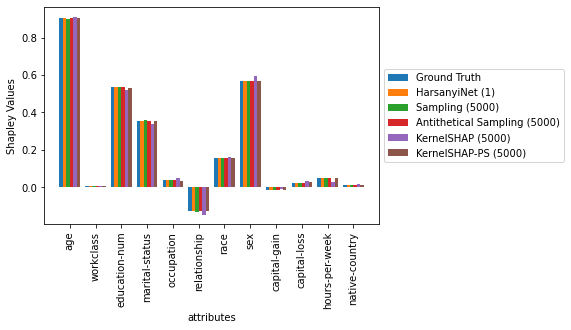

In [11]:
fig, ax = plt.subplots()
total_width = 0.8
single_width = 1
n_bars = len(data)
bar_width = total_width / n_bars
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bars = []
for i, (label, values) in enumerate(data.items()):
    x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
    for x, y in enumerate(values):
        bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
    bars.append(bar[0])

ax.legend(bars, data.keys(),loc='center left', bbox_to_anchor=(1, 0.5))  
plt.xticks(range(len(attributes)),attributes, rotation='vertical')
plt.xlabel('attributes')
plt.ylabel('Shapley Values')
plt.show()